# Monitoramento de casos de CVID19 no Brasil.

**Este notebook tem como objetivo aplicar técnicas de análise da dados, somente para fins didáticos.**

### INFORMAÇÕES SOBRE AS BASES UTILIZADAS

* Base utilizada para extrair dados do Brasil e Estados [G1  Globo](https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/27/casos-de-coronavirus-no-brasil-em-27-de-marco.ghtml) Fonte: Ministério da Saúde até 15 de março; secretarias estaduais da Saúde a partir de 16 de março.Criado com Datawrapper

* Base utilizada para extrair dados dos Municipios [brasil.io](https://brasil.io/dataset/covid19/caso) Boletins informativos baseado no Ministério da Saúde e secretarias estaduais da Saúde.

* Base utilizada para extrair dados dos Mundial  [BNO News]( https://bnonews.com/index.php/2020/03/the-latest-coronavirus-cases ) Boletins informativos baseado nos dados da OMS.

* Base utilizada para extrair dados dos Mundial [OMS]( https://who.sprinklr.com)OMS.

* Base utilizada para extrair dados dos Estados [Ministério da Saúde]( https://covid.saude.gov.br/ )

*Nenhuma copia deste notebook é permitida sem citar a fonte original.*

In [1]:
#!pip install matplotlib

In [1]:
from jupyterthemes import jtplot as jt
import pandas as pd
import numpy as np
import cufflinks as cf
import wget
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly
import requests
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import folium
from folium.plugins import Search
import os
from branca.element import Template, MacroElement
import requests
import json
from pandas.io.json import json_normalize
from folium import plugins
from numpy import nan as NA
from plotly.offline import iplot
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
cf.go_offline()
plotly.offline.init_notebook_mode(connected=True)


In [2]:
#Requisição
headers = {
    'authority': 'xx9p7hp1p7.execute-api.us-east-1.amazonaws.com',
    'accept': 'application/json, text/plain, */*',
    'sec-fetch-dest': 'empty',
    'x-parse-application-id': 'unAFkcaNDeXajurGB7LChj8SgQYS2ptm',
    'origin': 'https://covid.saude.gov.br',
    'sec-fetch-site': 'cross-site',
    'sec-fetch-mode': 'cors',
    'referer': 'https://covid.saude.gov.br/',
    'accept-language': 'en-US,en;q=0.9,pt;q=0.8',
}
geral = requests.get('https://xx9p7hp1p7.execute-api.us-east-1.amazonaws.com/prod/PortalGeral', headers=headers)
geral = json.loads(geral.content)['results']
geral = pd.DataFrame(geral)
link= json_normalize(geral['arquivo']) 
url_ms = str(link.name.values).replace('[', '')
url_ms = str(url_ms).replace(']', '')
url_ms = str(url_ms).replace("'", '')




C:\Users\joner\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



## Carregamento e Tratamento dos Dados

In [3]:

################################downloads######################################################### 
url_brasil_io = 'https://brasil.io/dataset/covid19/caso?format=csv'
if os.path.exists('DB/api_br_io.csv'):
    os.remove('DB/api_br_io.csv')
    wget.download(url_brasil_io, 'DB/api_br_io.csv')
else:
    wget.download(url_brasil_io, 'DB/api_br_io.csv')
################################################################################################### 
#A URL muda diariamente 
url_ministerio_saude = ('https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/'+url_ms)
if os.path.exists('DB/ministerio_saude.xlsx'):
    os.remove('DB/ministerio_saude.xlsx')
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.xlsx')
else:
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.xlsx')



100% [..........................................................................] 6368672 / 6368672

In [4]:
url_ministerio_saude

'https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/561126ce43be8c5dc4f8e016a17a7e1a_HIST_PAINEL_COVIDBR_28mai2020.xlsx'

In [5]:
###############################read_csv######################################################### 
estados = pd.read_csv('DB/estados.csv', encoding='utf-8')
municipios = pd.read_csv('DB/municipios.csv', encoding='utf-8')
api_br_io = pd.read_csv('DB/api_br_io.csv')
api_br_io = api_br_io.fillna(0)
api_br_io.city_ibge_code = api_br_io.city_ibge_code.astype('int64')
url_estados = 'DB/estados.json'
cidades = pd.read_json(url_estados)
municipios_map = json_normalize(cidades.features)  
#casos = pd.read_csv('DB/ministerio_saude.csv', sep=';', encoding='cp1252')

########################################################################

C:\Users\joner\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [6]:
#renomeando colunas
municipios.columns = ['city_ibge_code','city','latitude','longitude','capital','uf_code']
#casos.columns = ['regiao','sigla','data','casosNovos','casosAcumulados','obitosNovos','obitosAcumulados']

#tratando nomes para fazer o merge
estados = estados[['uf', 'nome']]
estados.columns = ['state','state_name']
cidades = api_br_io.merge(municipios.drop('uf_code', axis=1), on=['city','city_ibge_code'], how='left')
cidades = cidades.merge(estados, on='state', how='left')

cidades = cidades[(cidades.is_last==True) & (cidades.city !='Importados/Indefinidos')]
dadosCidades = cidades[ cidades.latitude.notnull() ]
cidades = dadosCidades[dadosCidades.place_type == 'city']
estados_brasil = dadosCidades[dadosCidades.capital == 1.0]
#saude = pd.DataFrame(casos)
cidades

date state                    city place_type  confirmed  deaths  \
0      2020-05-28    AL                  Anadia       city         29       1   
1      2020-05-28    AL               Arapiraca       city        322      11   
2      2020-05-28    AL                 Atalaia       city         91       3   
3      2020-05-28    AL  Barra de Santo Antônio       city         15       2   
4      2020-05-28    AL     Barra de São Miguel       city         19       1   
...           ...   ...                     ...        ...        ...     ...   
12098  2020-05-25    RR               Pacaraima       city         96       3   
12099  2020-05-25    RR            Rorainópolis       city        109       3   
12100  2020-05-25    RR      São João da Baliza       city         18       0   
12101  2020-05-25    RR                São Luiz       city         29       1   
12102  2020-05-25    RR                Uiramutã       city          2       1   

       is_last  estimated_population_2019  city_ibge_code  \
0         True                    17545.0         2700201   
1         True                   231747.0         2700300   
2         True                    47185.0         2700409   
3         True                    15932.0         2700508   
4         True                     8322.0         2700607   
...        ...                        ...             ...   
12098     True                    17401.0         1400456   
12099     True                    30163.0         1400472   
12100     True                     8201.0         1400506   
12101     True                     7986.0         1400605   
12102     True                    10559.0         1400704   

       confirmed_per_100k_inhabitants  death_rate  latitude  longitude  \
0                           165.28926      0.0345 -9.684890   -36.3078   
1                           138.94462      0.0342 -9.754870   -36.6615   
2                           192.85790      0.0330 -9.511900   -36.0086   
3                            94.15014      0.1333 -9.402300   -35.5101   
4                           228.31050      0.0526 -9.838420   -35.9057   
...                               ...         ...       ...        ...   
12098                       551.69243      0.0312  4.479900   -61.1477   
12099                       361.36989      0.0275  0.939956   -60.4389   
12100                       219.48543      0.0000  0.951659   -59.9133   
12101                       363.13549      0.0345  1.010190   -60.0419   
12102                        18.94119      0.5000  4.603140   -60.1815   

       capital state_name  
0          0.0    Alagoas  
1          0.0    Alagoas  
2          0.0    Alagoas  
3          0.0    Alagoas  
4          0.0    Alagoas  
...        ...        ...  
12098      0.0    Roraima  
12099      0.0    Roraima  
12100      0.0    Roraima  
12101      0.0    Roraima  
12102      0.0    Roraima  

[4046 rows x 15 columns]

### Criando dados gerais do Brasil

In [7]:
dados = saude.copy()
dadoslimpo = dados.dropna()
dadoslimpo['casosNovos'] = pd.to_numeric(dadoslimpo['casosNovos'])
dadoslimpo['obitosNovos'] = pd.to_numeric(dadoslimpo['obitosNovos'])
dadoslimpo['casosAcumulados'] = pd.to_numeric(dadoslimpo['casosAcumulados'])
dadoslimpo['obitosAcumulados'] = pd.to_numeric(dadoslimpo['obitosAcumulados'])
#dadoslimpo['data'] = pd.to_datetime(dadoslimpo['data'], format='%d-%m-%Y')

casosNovosDia = dadoslimpo['casosNovos'].groupby(dadoslimpo['data']).sum()
casosNovosDia = casosNovosDia[(casosNovosDia.index >= '2020-02-26')].reset_index()

obitosNovosDia = dadoslimpo['obitosNovos'].groupby(dadoslimpo['data']).sum()
obitosNovosDia = obitosNovosDia[(obitosNovosDia.index >= '2020-02-26')].reset_index()

casosNovos = dadoslimpo['casosNovos'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
casosNovos = casosNovos[casosNovos>=0].reset_index().drop('data',axis=1)

obitosNovos = dadoslimpo['obitosNovos'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
obitosNovos = obitosNovos[obitosNovos>=0].reset_index().drop('data',axis=1)

mortesTotal = dadoslimpo['obitosAcumulados'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
mortesTotal = mortesTotal[(mortesTotal.index >= '2020-02-26')].reset_index()

casosTotal = dadoslimpo['casosAcumulados'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
casosTotal = casosTotal[(casosTotal.index >= '2020-02-26')].reset_index()


NameError: name 'saude' is not defined

# Gráficos Brasil

In [22]:
#api_br_io[ (api_br_io.state == 'RS')]

In [9]:
dataRS =api_br_io[ api_br_io.city.notnull() ]
rs = dataRS [ (dataRS.state == 'RS')&(dataRS.date == '2020-05-27') & (dataRS.place_type =='city')].sort_values(by='confirmed',ascending=False)
rs.groupby(['city'] )
rs.fillna(0, inplace = True)
fig = go.Figure(data=[go.Table(
    header=dict(values=['Cidades  % '+ str(round(rs.city.size*100/497,2)) +'<br><b>Total--</b>'+str(rs.city.size) +'</br>' ,
                        '<br>Confirmados</br> <b>Total-</b>'+ str(rs.confirmed.sum()),
                        '<br>Mortes</br>  <b>Total-</b>'+ str(rs.deaths.sum().astype(int))],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[rs.city, rs.confirmed,rs.deaths],
               fill_color='lavender',
               align='left'))
])

fig.show()
plotly.offline.plot(fig, filename='HTML/TabelaCovid19RS.html', auto_open=False)

'HTML/TabelaCovid19RS.html'

In [10]:
#![Tabela1 casos confirmados por cidades do RS](IMG/Alegrete.jpg)

In [11]:
import plotly.express as px


fig = px.bar(rs.head(10), y='city', x='confirmed',color='deaths', text='confirmed',orientation='h')

fig.update_traces( textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [12]:
cidades

date state                    city place_type  confirmed  deaths  \
0      2020-05-28    AL                  Anadia       city         29       1   
1      2020-05-28    AL               Arapiraca       city        322      11   
2      2020-05-28    AL                 Atalaia       city         91       3   
3      2020-05-28    AL  Barra de Santo Antônio       city         15       2   
4      2020-05-28    AL     Barra de São Miguel       city         19       1   
...           ...   ...                     ...        ...        ...     ...   
12098  2020-05-25    RR               Pacaraima       city         96       3   
12099  2020-05-25    RR            Rorainópolis       city        109       3   
12100  2020-05-25    RR      São João da Baliza       city         18       0   
12101  2020-05-25    RR                São Luiz       city         29       1   
12102  2020-05-25    RR                Uiramutã       city          2       1   

       is_last  estimated_population_2019  city_ibge_code  \
0         True                    17545.0         2700201   
1         True                   231747.0         2700300   
2         True                    47185.0         2700409   
3         True                    15932.0         2700508   
4         True                     8322.0         2700607   
...        ...                        ...             ...   
12098     True                    17401.0         1400456   
12099     True                    30163.0         1400472   
12100     True                     8201.0         1400506   
12101     True                     7986.0         1400605   
12102     True                    10559.0         1400704   

       confirmed_per_100k_inhabitants  death_rate  latitude  longitude  \
0                           165.28926      0.0345 -9.684890   -36.3078   
1                           138.94462      0.0342 -9.754870   -36.6615   
2                           192.85790      0.0330 -9.511900   -36.0086   
3                            94.15014      0.1333 -9.402300   -35.5101   
4                           228.31050      0.0526 -9.838420   -35.9057   
...                               ...         ...       ...        ...   
12098                       551.69243      0.0312  4.479900   -61.1477   
12099                       361.36989      0.0275  0.939956   -60.4389   
12100                       219.48543      0.0000  0.951659   -59.9133   
12101                       363.13549      0.0345  1.010190   -60.0419   
12102                        18.94119      0.5000  4.603140   -60.1815   

       capital state_name  
0          0.0    Alagoas  
1          0.0    Alagoas  
2          0.0    Alagoas  
3          0.0    Alagoas  
4          0.0    Alagoas  
...        ...        ...  
12098      0.0    Roraima  
12099      0.0    Roraima  
12100      0.0    Roraima  
12101      0.0    Roraima  
12102      0.0    Roraima  

[4046 rows x 15 columns]

In [13]:
import codecs
br_estados = 'DB/br_states.json'
geo_json_estados = json.load(codecs.open(br_estados, 'r', 'utf-8'))
br_municipios= 'DB/br_states2.json'
geo_json_municipios = json.load(codecs.open(br_municipios, 'r', 'cp1252'))
covid_cidades= cidades.copy()
#covid_estados= estados_brasil.copy()
df_bsb =covid_cidades[( covid_cidades.city.notnull()) & (covid_cidades.place_type =='city') ]
#df_estados =covid_estados[( covid_estados.city.notnull()) & (covid_estados.place_type =='city')& (covid_estados.state =='RS') ]
teste = cidades[['state','confirmed','deaths','death_rate']].groupby(cidades['state']).sum()
#df_estados = estados_brasil.drop(['capital'], axis=1 ).merge(teste, on='state')
df_bsb['date'] = df_bsb['date'].apply(lambda x: pd.Timestamp(x).strftime('%d-%m-%Y'))

#cidades_captais= cidades[cidades.capital==1][['state','latitude','longitude','confirmed']]
#df_estados = estados_brasil.drop(['latitude','longitude', 'capital'], axis=1 ).merge(cidades_captais, on='state')
df_bsb

date state                    city place_type  confirmed  deaths  \
0      28-05-2020    AL                  Anadia       city         29       1   
1      28-05-2020    AL               Arapiraca       city        322      11   
2      28-05-2020    AL                 Atalaia       city         91       3   
3      28-05-2020    AL  Barra de Santo Antônio       city         15       2   
4      28-05-2020    AL     Barra de São Miguel       city         19       1   
...           ...   ...                     ...        ...        ...     ...   
12098  25-05-2020    RR               Pacaraima       city         96       3   
12099  25-05-2020    RR            Rorainópolis       city        109       3   
12100  25-05-2020    RR      São João da Baliza       city         18       0   
12101  25-05-2020    RR                São Luiz       city         29       1   
12102  25-05-2020    RR                Uiramutã       city          2       1   

       is_last  estimated_population_2019  city_ibge_code  \
0         True                    17545.0         2700201   
1         True                   231747.0         2700300   
2         True                    47185.0         2700409   
3         True                    15932.0         2700508   
4         True                     8322.0         2700607   
...        ...                        ...             ...   
12098     True                    17401.0         1400456   
12099     True                    30163.0         1400472   
12100     True                     8201.0         1400506   
12101     True                     7986.0         1400605   
12102     True                    10559.0         1400704   

       confirmed_per_100k_inhabitants  death_rate  latitude  longitude  \
0                           165.28926      0.0345 -9.684890   -36.3078   
1                           138.94462      0.0342 -9.754870   -36.6615   
2                           192.85790      0.0330 -9.511900   -36.0086   
3                            94.15014      0.1333 -9.402300   -35.5101   
4                           228.31050      0.0526 -9.838420   -35.9057   
...                               ...         ...       ...        ...   
12098                       551.69243      0.0312  4.479900   -61.1477   
12099                       361.36989      0.0275  0.939956   -60.4389   
12100                       219.48543      0.0000  0.951659   -59.9133   
12101                       363.13549      0.0345  1.010190   -60.0419   
12102                        18.94119      0.5000  4.603140   -60.1815   

       capital state_name  
0          0.0    Alagoas  
1          0.0    Alagoas  
2          0.0    Alagoas  
3          0.0    Alagoas  
4          0.0    Alagoas  
...        ...        ...  
12098      0.0    Roraima  
12099      0.0    Roraima  
12100      0.0    Roraima  
12101      0.0    Roraima  
12102      0.0    Roraima  

[4046 rows x 15 columns]

In [14]:
from folium.plugins import MarkerCluster

# Mapa do Brasil municípios com COVID-19

In [15]:

#icon_path = 'IMG/icon.png'
#icon = folium.features.CustomIcon(icon_image=icon_path ,icon_size=(50,50))
brasil = folium.Map(location=[-15.77972, -47.92972], tiles='OpenStreetMap',zoom_start=4)
#Malha territorial Estados
statesgeo = folium.GeoJson(
    geo_json_estados, name='Estados',
    style_function=lambda feature: { 
      'fillOpacity': 0.9,
        'weight': 0.1,
        'fillColor': 'white'
    }

).add_to(brasil)

plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(brasil)

#Controlador de Camadas
fg1=folium.FeatureGroup(name='De 1 a 50', show=True)
brasil.add_child(fg1)
fg2=folium.FeatureGroup(name='De 50 a 100', show=True)
brasil.add_child(fg2)
fg3=folium.FeatureGroup(name='De 100 a 1000', show=True)
brasil.add_child(fg3)
fg4=folium.FeatureGroup(name='Acima de 1000', show=True)
brasil.add_child(fg4)


#Add legenda
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>COVID-19 Brasil</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Nº de Casos</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.7;'></span>De 1 a 50</li>
    <li><span style='background:yellow;opacity:0.7;'></span>De 50 a 100</li>
    <li><span style='background:red;opacity:0.7;'></span>De 100 a 1000</li>
    <li><span style='background:black;opacity:0.7;'></span>Acima de 1000</li>
  </ul>
   <p>
     Fonte: Brasil.io,IBGE.
     </p>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

brasil.get_root().add_child(macro)


#percorre o Df 
for _, dados in df_bsb.iterrows():
    
    html = """
    <h1> """+ dados.city + """</h1><br>
    <b>Casos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.confirmed) + """</font></b><br>
    <b>Óbitos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.deaths) + """</font></b><br>
    <b>Mortalidade:&nbsp;<font size="2" face="Verdana">"""+ str("{0:.2%}".format(dados.death_rate)) + """</font></b><br>
    <p>
    <b>Data:&nbsp;<font size="2" face="Verdana">"""+ str(dados.date) + """</font></b><br>
    </p>
    """

    if (dados['confirmed']>=1) & (dados['confirmed']<50):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=10000,
        color='green',
        stroke= False,
        fill=True,
        fill_color='green',
        opacity=0.5,
        fill_opacity=0.5
        #Stroke_opacity=70
        ).add_to(fg1)


    if (dados['confirmed']>=50) & ( dados['confirmed']<100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=50000,
        color='yellow',
        stroke= False,
        fill=True,
        fill_color='yellow',
        opacity=0.6,
        fill_opacity=0.6
        #Stroke_opacity=70
        ).add_to(fg2)
 
    if ((dados['confirmed']>=100) & ( dados['confirmed']<1000)):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=50000,
        color='red',
        stroke= False,
        fill=True,
        fill_color='red',
        opacity=0.5,
        fill_opacity=0.5
        #Stroke_opacity=70
        ).add_to(fg3)
        
    if (dados['confirmed']>=1000):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=50000,
        color='black',
        stroke= False,
        fill=True,
        fill_color='black',
        opacity=0.7,
        fill_opacity=0.7
        #Stroke_opacity=70
        ).add_to(fg4)
"""
stategeo = folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: { 
         
        'fillColor': 'darkred',
        'color': 'darkred',
        'weight': 0.5,
    }
).add_to(brasil)
 """ 
#add busca por estado
statesearch = Search(
    layer=statesgeo,
    geom_type='Polygon',
    placeholder='Pesquisar Estado',
    collapsed=False,
    search_label='name',
    weight=3
).add_to(brasil)

folium.raster_layers.WmsTileLayer(
    url='#',
    #name='test',
    fmt='image/png',
    layers='nexrad-n0r-900913',
    attr='Joner Mello data © 2020',
    transparent=True,
    overlay=True,
    control=False,
).add_to(brasil)

folium.LayerControl().add_to(brasil)
brasil.save('HTML/MapaBrasilCovid19.html')


# Mapa do Brasil Estados com COVID-19

In [29]:
#icon_path = 'IMG/icon.png'
#icon = folium.features.CustomIcon(icon_image=icon_path ,icon_size=(50,50))
vis2 = df_estados
brasil = folium.Map(location=[-15.77972, -47.92972], tiles='OpenStreetMap',zoom_start=4)
#Malha territorial Estados
statesgeo = folium.GeoJson(
    geo_json_estados, name='Estados',
    
    style_function=lambda feature: { 
      'fillOpacity': 0.9,
        'weight': 0.1,
        'fillColor': 'white'
    }

).add_to(brasil)
#Controlador de Camadas
fg1=folium.FeatureGroup(name='De 1 a 50', show=True)
brasil.add_child(fg1)
fg2=folium.FeatureGroup(name='De 50 a 100', show=True)
brasil.add_child(fg2)
fg3=folium.FeatureGroup(name='De 100 a 1000', show=True)
brasil.add_child(fg3)
fg4=folium.FeatureGroup(name='Acima de 1000', show=True)
brasil.add_child(fg4)


#Add legenda
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>COVID-19 Brasil</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Nº de Casos</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.7;'></span>De 1 a 50</li>
    <li><span style='background:yellow;opacity:0.7;'></span>De 50 a 100</li>
    <li><span style='background:red;opacity:0.7;'></span>De 100 a 1000</li>
    <li><span style='background:black;opacity:0.7;'></span>Acima de 1000</li>
     <p>
     Fonte: Brasil.io,IBGE.
     </p>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

brasil.get_root().add_child(macro)


#percorre o Df 
for _, dados in df_estados.iterrows():
    
    html = """
    <h1> """+ dados.city + """</h1><br>
    <b>Casos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.confirmed_y) + """</font></b><br>
    <b>Óbitos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.deaths_y) + """</font></b><br>
    <b>Mortalidade:&nbsp;<font size="2" face="Verdana">"""+ str("{0:.2f}".format(dados.death_rate_y)) + """</font></b><br>
    <p>
    <b>Data:&nbsp;<font size="2" face="Verdana">"""+ str(dados.date) + """</font></b><br>
    </p>
    """


    if (dados['confirmed_y']>=1) & (dados['confirmed_y']<50):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=dados['confirmed_y']*10,
        color='green',
        stroke= False,
        fill=True,
        fill_color='green',
        opacity=0.5,
        fill_opacity=0.5
        #Stroke_opacity=70
        ).add_to(fg1)


    if (dados['confirmed_y']>=50) & ( dados['confirmed_y']<100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=dados['confirmed_y']*10,
        color='yellow',
        stroke= False,
        fill=True,
        fill_color='yellow',
        opacity=0.6,
        fill_opacity=0.6
        #Stroke_opacity=70
        ).add_to(fg2)
 
    if ((dados['confirmed_y']>=100) & ( dados['confirmed_y']<1000)):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=dados['confirmed_y']*10,
        color='red',
        stroke= False,
        fill=True,
        fill_color='red',
        opacity=0.5,
        fill_opacity=0.5
        #Stroke_opacity=70
        ).add_to(fg3)
        
    if (dados['confirmed_y']>=1000):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup=html,
        radius=dados['confirmed_y']*10,
        color='black',
        stroke= False,
        fill=True,
        fill_color='black',
        opacity=0.7,
        fill_opacity=0.7
        #Stroke_opacity=70
        ).add_to(fg4)
"""
stategeo = folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: { 
         
        'fillColor': 'darkred',
        'color': 'darkred',
        'weight': 0.5,
    }
).add_to(brasil)
 """ 
#add busca por estado
statesearch = Search(
    layer=statesgeo,
    geom_type='Polygon',
    placeholder='Pesquisar Estado',
    collapsed=False,
    search_label='name',
    weight=3
).add_to(brasil)


folium.LayerControl().add_to(brasil)

brasil.save('HTML/MapaBrasilEstadosCovid19.html')

NameError: name 'df_estados' is not defined

In [31]:
#![Figura6 casos no RS ](IMG/RScasosDISTRI.jpg)

In [32]:
from datetime import datetime
now = datetime.now()

In [33]:
#hack ministério da saéde
print (str(now.year)+str(now.month)+str(now.day))



202058


In [23]:
from folium.plugins import MarkerCluster
m = folium.Map(location=[-15.77972, -47.92972], zoom_start=4)

marker_cluster = MarkerCluster().add_to(m)
for _, dados in df_bsb.iterrows():

    html = """
    <h1> """+ dados.city + """</h1><br>
    <b>Casos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.confirmed) + """</font></b><br>
    <b>Óbitos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.deaths) + """</font></b><br>
    <b>Mortalidade:&nbsp;<font size="2" face="Verdana">"""+ str("{0:.2%}".format(dados.death_rate)) + """</font></b><br>
    <p>
    <b>Data:&nbsp;<font size="2" face="Verdana">"""+ str(dados.date) + """</font></b><br>
    </p>
    """  

folium.Marker(
    location=[dados['latitude'], dados['longitude']],
    popup=html,
    icon=None,
).add_to(marker_cluster)


m.save('HTML/Mapa.html')


In [30]:
def sir_model(y, t, beta, gamma):
    S, I, R = y
    
    dS_dt = -beta*S*I
    dI_dt = beta*S*I - gamma*I
    dR_dt = gamma*I
    
    return [dS_dt, dI_dt, dR_dt]

In [31]:

import scipy.integrate
import numpy
# Total população, N.
N = 209.5*10**6 
#Número inicial de indivíduos infectados e recuperados, I0 e R0.
I0, R0 = 177589, 72597
#Todos os outros, S0, são suscetíveis à infecção inicialmente.
S0 = N - I0 - R0
# Taxa de contato, beta e taxa de recuperação média, gama, (em 1 / dias).
beta, gamma = 1.1, 1/5.2 
# Uma grade de pontos no tempo (em dias)

t = np.linspace(0, 160, 160)

# condições iniciais
S0 = 0.9
I0 = 0.1
R0 = 0.0
beta = 0.35
gamma = 0.1

# Time vector
t = numpy.linspace(0, 100, 10000)

# Result
solucao = scipy.integrate.odeint(sir_model, [S0, I0, R0], t, args=(beta, gamma))
solucao = numpy.array(solucao)

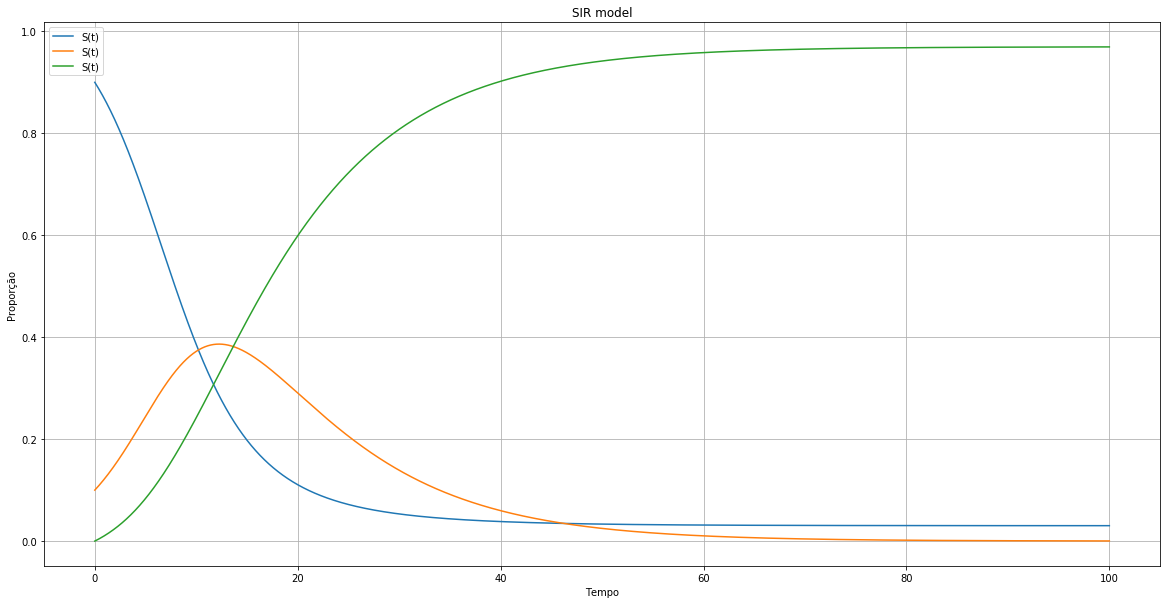

In [32]:

plt.figure(figsize=[20,10])
plt.plot(t, solucao[:, 0], label="S(t)")
plt.plot(t, solucao[:, 1], label="S(t)")
plt.plot(t, solucao[:, 2], label="S(t)")
plt.grid()
plt.legend()
plt.xlabel("Tempo")
plt.ylabel("Proporção")
plt.title("SIR model")

plt.show()

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from datetime import datetime as dt
from IPython.display import Image
from IPython.display import HTML

In [17]:

df = dadoslimpo.copy()
#df['data'] = df['data'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d',errors='coerce', dayfirst=False)
df['data'] = df['data'].dt.tz_localize(None)
df

NameError: name 'dadoslimpo' is not defined

In [41]:
current_year = '2020-05-06'
dff = (df[df['data'].eq(current_year)]
       .sort_values(by='casosAcumulados', ascending=True)
       .head(27))
dff

regiao sigla       data  casosNovos  casosAcumulados  obitosNovos  \
2374  Centro-Oeste    MS 2020-05-06           5              288            0   
691          Norte    TO 2020-05-06          48              351            2   
2473  Centro-Oeste    MT 2020-05-06          14              379            0   
394          Norte    RR 2020-05-06          63              932            2   
97           Norte    RO 2020-05-06          82              943            4   
196          Norte    AC 2020-05-06         126              943            4   
889       Nordeste    PI 2020-05-06          74              949            1   
1483      Nordeste    SE 2020-05-06         100              998            2   
2572  Centro-Oeste    GO 2020-05-06         102             1024            6   
1186      Nordeste    PB 2020-05-06         132             1493            7   
1087      Nordeste    RN 2020-05-06          38             1574            4   
2077           Sul    PR 2020-05-06          39             1627            2   
1384      Nordeste    AL 2020-05-06          97             1703            9   
2671  Centro-Oeste    DF 2020-05-06          88             1906            1   
592          Norte    AP 2020-05-06         115             2046            1   
2275           Sul    RS 2020-05-06         235             2050            8   
1681       Sudeste    MG 2020-05-06         153             2605            3   
2176           Sul    SC 2020-05-06         294             2917            4   
1780       Sudeste    ES 2020-05-06         166             3568           12   
1582      Nordeste    BA 2020-05-06         261             4301           14   
493          Norte    PA 2020-05-06         545             5017           23   
790       Nordeste    MA 2020-05-06         498             5028           20   
295          Norte    AM 2020-05-06        1134             9243          102   
1285      Nordeste    PE 2020-05-06         556             9881           54   
988       Nordeste    CE 2020-05-06         834            12304           53   
1879       Sudeste    RJ 2020-05-06         904            13295           82   
1978       Sudeste    SP 2020-05-06        3800            37853          194   

      obitosAcumulados  
2374                10  
691                  9  
2473                13  
394                 13  
97                  33  
196                 33  
889                 30  
1483                23  
2572                44  
1186                92  
1087                72  
2077               101  
1384                89  
2671                34  
592                 56  
2275                87  
1681                97  
2176                59  
1780               145  
1582               160  
493                392  
790                291  
295                751  
1285               803  
988                848  
1879              1205  
1978              3045

In [42]:
#fig, ax = plt.subplots(figsize=(15, 8))
#ax.barh(dff['sigla'], dff['casosAcumulados'])

In [43]:
img = Image(url= "https://www.countryflags.io/br/flat/64.png", width=20, height=20)


In [44]:
import matplotlib.pyplot as plt
import random

paths = dict(zip(
   ['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN',
       'PB', 'PE', 'AL', 'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC',
       'RS', 'MS', 'MT', 'GO', 'DF'],
   ['RO.png', 'AC.png', 'AM.png', 'RR.png', 'PA.png', 'AP.png', 'TO.png', 'MA.png', 'PI.png', 'CE.png', 'RN.png',
       'PB.png', 'PE.png', 'AL.png', 'SE.png', 'BA.png', 'MG.png', 'ES.png', 'RJ.png', 'SP.png', 'PR.png', 'SC.png',
       'RS.png', 'MS.png', 'MT.png', 'GO.png', 'DF.png']
))
#cores estaticas
colors = dict(zip(
   ['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN',
       'PB', 'PE', 'AL', 'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC',
       'RS', 'MS', 'MT', 'GO', 'DF'],
['#93F569',
 '#81734D',
 '#0894BF',
 '#7F24FD',
 '#5F98BA',
 '#F98360',
 '#64EFCA',
 '#1A335F',
 '#DE79DF',
 '#12634D',
 '#08D7F2',
 '#757428',
 '#D2DBDF',
 '#6F1DA8',
 '#697F99',
 '#F8F175',
 '#E20361',
 '#22EBE1',
 '#015E63',
 '#B23883',
 '#DBCBE3',
 '#02B533',
 '#B3391D',
 '#B3391D',
 '#C0EF60',
 '#F5CA07',
 '#FCBD03']
))
#cores aleatórias
#number_of_colors = 27

#colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#             for i in range(number_of_colors)]
group_lk = df.set_index('data')['sigla'].to_dict()


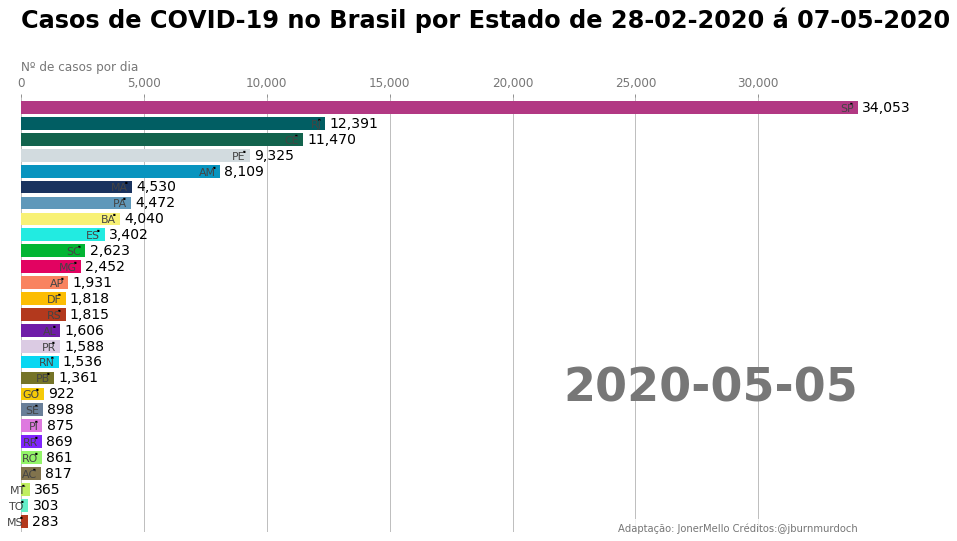

In [45]:
current_date = '2020-05-05'
fig, ax = plt.subplots(figsize=(15, 8))
def draw_barchart(date):
    dff = df[df['data'].eq(date)].sort_values(by='casosAcumulados', ascending=True).tail(27)
    ax.clear()
    ax.barh(dff['sigla'], dff['casosAcumulados'], color=[colors[x] for x in dff['sigla']])
    dx = dff['casosAcumulados'].max() / 200
    for i, (value, name) in enumerate(zip(dff['casosAcumulados'], dff['sigla'])):
        ax.text(value-dx, i, """.""", size=12, weight=600, ha='right', va='bottom')
        ax.text(value-dx, i-.25,name, size=11, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    # ... polished styles
    ax.text(1, 0.3, date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Nº de casos por dia', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12,  )
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.16, 'Casos de COVID-19 no Brasil por Estado de 28-02-2020 á 07-05-2020',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    ax.text(1, 0, 'Adaptação: JonerMello Créditos:@jburnmurdoch', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    
draw_barchart(current_date)

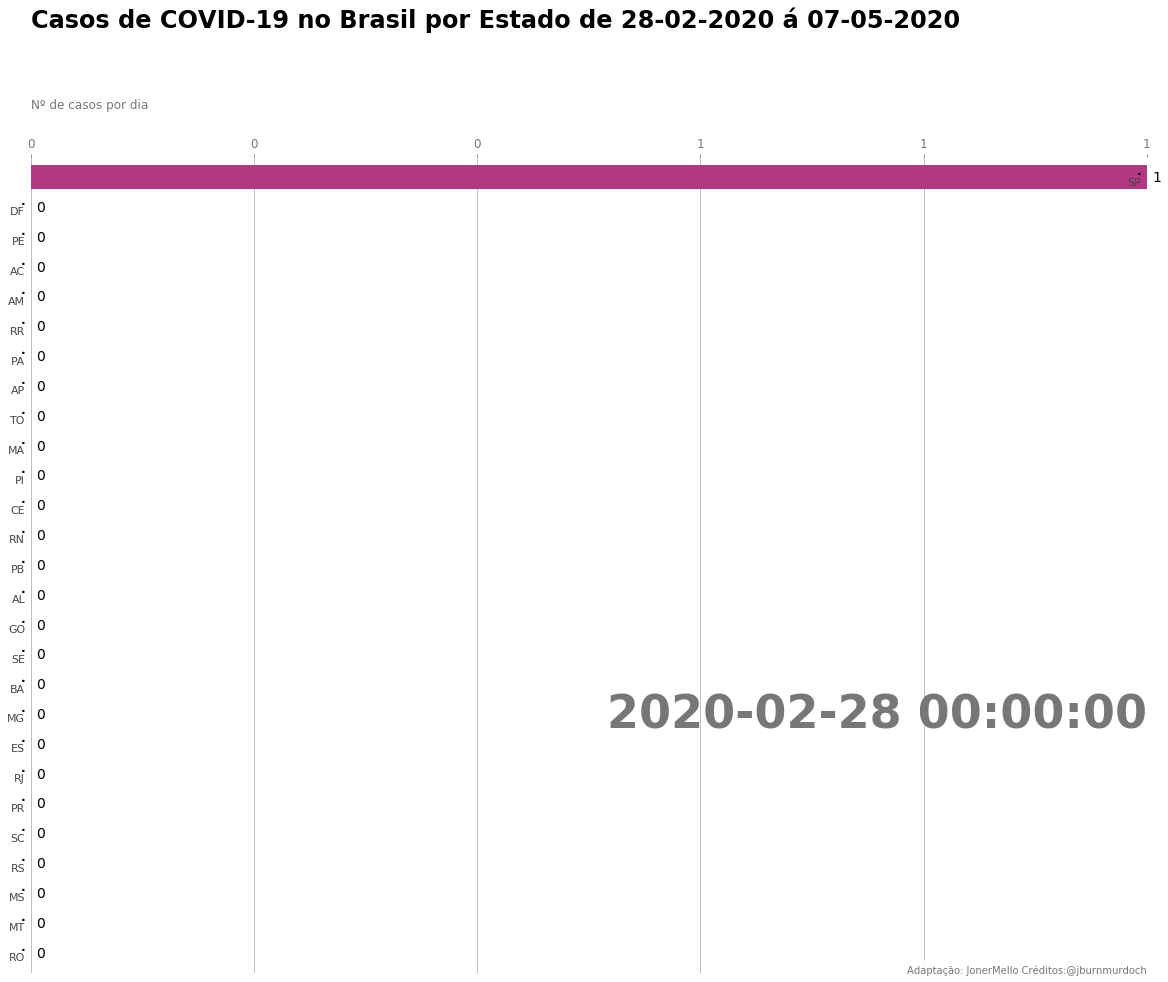

In [46]:
import matplotlib.animation as animation
from IPython.display import HTML
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(20, 15))
    animator = animation.FuncAnimation(fig, draw_barchart, frames=pd.date_range(start='2020-02-28', end='2020-05-06'))
HTML(animator.to_jshtml())
#mywriter = animation.FFMpegWriter(fps=3)
#animator.save('covid-19BR.mp4', writer=mywriter)
# or use animator.to_html5_video() or animator.save()

In [578]:
import pandas as pd
import requests
import json
#Requisição
headers = {
    'authority': 'xx9p7hp1p7.execute-api.us-east-1.amazonaws.com',
    'accept': 'application/json, text/plain, */*',
    'sec-fetch-dest': 'empty',
    'x-parse-application-id': 'unAFkcaNDeXajurGB7LChj8SgQYS2ptm',
    'origin': 'https://covid.saude.gov.br',
    'sec-fetch-site': 'cross-site',
    'sec-fetch-mode': 'cors',
    'referer': 'https://covid.saude.gov.br/',
    'accept-language': 'en-US,en;q=0.9,pt;q=0.8',
}
total = requests.get('https://xx9p7hp1p7.execute-api.us-east-1.amazonaws.com/prod/PortalAcumulo', headers=headers)
mapa = requests.get('https://xx9p7hp1p7.execute-api.us-east-1.amazonaws.com/prod/PortalMapa', headers=headers)
geral = requests.get('https://xx9p7hp1p7.execute-api.us-east-1.amazonaws.com/prod/PortalGeral', headers=headers)
semana = requests.get('https://xx9p7hp1p7.execute-api.us-east-1.amazonaws.com/prod/PortalSemana', headers=headers)
dia = requests.get('https://xx9p7hp1p7.execute-api.us-east-1.amazonaws.com/prod/PortalDias', headers=headers)
regiao = requests.get('https://xx9p7hp1p7.execute-api.us-east-1.amazonaws.com/prod/PortalRegiao', headers=headers)
#Transformando json
total = json.loads(total.content)['results']
mapa = json.loads(mapa.content)['results']
geral = json.loads(geral.content)['results']
semana = json.loads(semana.content)['results']
dia = json.loads(dia.content)['results']
regiao = json.loads(regiao.content)['results']
#Criando os DF
mapa = pd.DataFrame(mapa)
mapa = mapa.drop(['objectId',  'createdAt', 'percent'], axis=1)
acumulado = pd.DataFrame(total)
acumulado = acumulado.drop(['objectId', 'createdAt'], axis=1)
geral = pd.DataFrame(geral)
geral = geral.drop(['objectId','createdAt','updatedAt','versao','arquivo','arquivo_srag'], axis=1)
semana = pd.DataFrame(semana)
semana = semana.drop(['objectId','createdAt','updatedAt'], axis=1)
dia = pd.DataFrame(dia)
dia = dia.drop(['objectId','createdAt','updatedAt'], axis=1)
regiao = pd.DataFrame(regiao)
regiao = regiao.drop(['objectId','color','percent','createdAt','updatedAt'], axis=1)
#Gera os acquivos CSV
mapa.to_csv('covid_mapa_br.csv')
acumulado.to_csv('covid_acumulado_br.csv')
geral.to_csv('covid_geral_br.csv') 
semana.to_csv('covid_semana_br.csv') 
dia.to_csv('covid_dia_br.csv')
regiao.to_csv('covid_regiao_br.csv') 

In [579]:

mapa

nome  qtd_confirmado  latitude longitude  \
0                  Acre            1014  -9.97499  -67.8243   
1               Alagoas            1867  -9.66599   -35.735   
2                 Amapá            2199  0.034934  -51.0694   
3              Amazonas           10099  -3.11866  -60.0212   
4                 Bahia            4528  -12.9718  -38.5011   
5                 Ceará           13888  -3.71664  -38.5423   
6      Distrito Federal            2258  -15.7795  -47.9297   
7        Espírito Santo            3838  -20.3155  -40.3128   
8                 Goiás            1027  -16.6864  -49.2643   
9              Maranhão            5389  -2.53874  -44.2825   
10          Mato Grosso             417   -15.601  -56.0974   
11   Mato Grosso do Sul             311  -20.4486  -54.6295   
12         Minas Gerais            2770  -19.9102  -43.9266   
13               Paraná            1656  -25.4195  -49.2646   
14              Paraíba            1657  -7.11509  -34.8641   
15                 Pará            5524   -1.4554  -48.4898   
16           Pernambuco           10824  -8.04666  -34.8771   
17                Piauí            1051  -5.09194  -42.8034   
18  Rio Grande do Norte            1739  -5.79357  -35.1986   
19    Rio Grande do Sul            2129  -30.0318  -51.2065   
20       Rio de Janeiro           14156  -22.9129  -43.2003   
21             Rondônia            1098  -8.76077  -63.8999   
22              Roraima            1020   2.82384  -60.6753   
23       Santa Catarina            3082  -27.5945  -48.5477   
24              Sergipe            1214  -10.9091  -37.0677   
25            São Paulo           39928  -23.5329  -46.6395   
26            Tocantins             423    -10.24  -48.3558   

                   updatedAt letalidade  qtd_obito  qtd_incidencia  
0   2020-05-07T22:08:44.022Z         41         36            1150  
1   2020-05-07T21:55:23.506Z         29         98             559  
2   2020-05-07T21:54:57.708Z         72         61            2600  
3   2020-05-07T21:55:47.049Z        194        806            2437  
4   2020-05-07T21:56:11.048Z         11        165             304  
5   2020-05-07T21:58:14.092Z         99        903            1521  
6   2020-05-07T21:56:31.207Z         12         35             749  
7   2020-05-07T21:57:37.684Z         39        155             955  
8   2020-05-07T21:58:33.948Z          6         44             146  
9   2020-05-07T21:57:01.201Z         43        305             762  
10  2020-05-07T22:10:07.090Z          4         13             120  
11  2020-05-07T22:02:55.258Z          4         10             112  
12  2020-05-07T21:59:52.547Z          5        106             131  
13  2020-05-07T22:01:30.216Z          9        104             145  
14  2020-05-07T22:04:31.649Z         25        101             412  
15  2020-05-07T21:59:03.685Z         48        410             642  
16  2020-05-07T22:00:14.455Z         88        845            1133  
17  2020-05-07T22:01:53.602Z         11         35             321  
18  2020-05-07T22:00:48.292Z         22         76             496  
19  2020-05-07T22:01:09.817Z          8         90             187  
20  2020-05-07T22:02:17.377Z         81       1394             820  
21  2020-05-07T22:02:38.811Z         21         37             618  
22  2020-05-07T22:03:36.129Z         23         14            1684  
23  2020-05-07T22:05:12.954Z          9         63             430  
24  2020-05-07T22:03:11.370Z         11         25             528  
25  2020-05-07T22:04:07.318Z         70       3206             870  
26  2020-05-07T22:04:48.136Z          6          9             269

In [580]:

acumulado

label  qtd_confirmado  qtd_obito                 updatedAt
0   26/02               1          0  2020-04-02T15:24:12.111Z
1   27/02               1          0  2020-03-25T22:33:28.073Z
2   28/02               1          0  2020-03-25T22:33:37.951Z
3   29/02               2          0  2020-03-25T22:33:47.790Z
4   01/03               2          0  2020-03-25T22:33:56.014Z
..    ...             ...        ...                       ...
67  03/05          101147       7025  2020-05-04T19:19:50.974Z
68  04/05          107780       7321  2020-05-04T22:56:42.594Z
69  05/05          114715       7921  2020-05-05T22:01:15.121Z
70  06/05          125218       8536  2020-05-06T21:45:39.533Z
71  07/05          135106       9146  2020-05-07T21:51:11.195Z

[72 rows x 4 columns]

In [581]:

geral


total_confirmado total_obitos    dt_atualizacao total_letalidade
0          135.106        9.146  19:10 07/05/2020             6,8%

In [582]:
#historico.to_csv('covid_historico_br.csv')
#ufs.to_csv('covid_por_uf.csv') 

In [583]:

semana


label  qtd_confirmado  qtd_obito
0     9ª               2          0
1    10ª              17          0
2    11ª             102          0
3    12ª            1007         18
4    13ª            2775         96
5    14ª            6375        318
6    15ª           10449        692
7    16ª           15872       1223
8    17ª           21910       1669
9    18ª           37887       2708
10   19ª           38710       2422

In [584]:

dia

label  qtd_confirmado  qtd_obito
0   26/02               1      123.0
1   27/02               0       34.0
2   28/02               0       35.0
3   29/02               1       45.0
4   01/03               0       55.0
..    ...             ...        ...
67  03/05            4751        NaN
68  04/05            6633        NaN
69  05/05            6935        NaN
70  06/05           10503        NaN
71  07/05            9888        NaN

[72 rows x 3 columns]

In [585]:

regiao

nome    qtd
0         Norte  21377
1      Nordeste  42157
2  Centro-Oeste   4013
3       Sudeste  60692
4           Sul   6867